In [1]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d
from uncertainties import ufloat

/home/dpirvu/.local/lib/python3.7/site-packages/


In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
nLat = 512
nTime = nLat
nTimemultiplier1 = 2
nTimemultiplier2 = 10

nSims = 100

phi0 = 1.
m2bare = 1.
lenLat = 100.
nCols = 2

nyq = nLat//2
spec = nyq

alpha = 8
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha

### Theoretical Field PS 

In [4]:
#sim_location = lambda nT, nL, m2, tem, phi, lam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_t'+str(nT)+'_x'+str(nL)+'_m2{:.4f}'.format(m2)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
#sim_location_eff = lambda nT, nL, m2, tem, phi, lam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_m2eff_t'+str(nT)+'_x'+str(nL)+'_m2{:.4f}'.format(m2)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
#smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma))

#def extract_sim(nT, nL, m2, tem, phi, lam, sim):
#    nTT = nT*nTimemultiplier1
#    data = np.genfromtxt(sim_location(nTT, nL, m2, tem, phi, lam, sim))
#    return np.asarray([np.reshape(data[:,col], (nTT, nL))[-nL:] for col in range(nCols)])

#def extract_eff_sim(nT, nL, m2, tem, phi, lam, sim):
#    nTT = nT*nTimemultiplier1
#    data = np.genfromtxt(sim_location_eff(nTT, nL, m2, tem, phi, lam, sim))
#    return np.asarray([np.reshape(data[:,col], (nTT, nL))[-nL:] for col in range(nCols)])

sim_location = lambda nT, nL, gam, m2, tem, phi, lam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_t'+str(nT)+'_x'+str(nL)+'_gam'+str(gam)+'_m2{:.4f}'.format(m2)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
eff_sim_location = lambda nT, nL, gam, m2, tem, phi, lam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_meffPS_t'+str(nT)+'_x'+str(nL)+'_gam'+str(gam)+'_m2{:.4f}'.format(m2)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma))

def extract_sim(nT, nL, gam, m2, tem, phi, lam, sim):
    nTT = nT*(nTimemultiplier1 if gam != 1 else nTimemultiplier2)
    import_time_list = np.asarray(np.arange(nL//2).tolist() + np.arange(nTT-nL,nTT).tolist())
    #import_time_list = np.arange(nTT-nL,nTT)

    data = np.genfromtxt(sim_location(nTT, nL, gam, m2, tem, phi, lam, sim))
    return np.asarray([np.reshape(data[:,col], (nTT, nL))[import_time_list] for col in range(nCols)])

def extract_sim_eff(nT, nL, gam, m2, tem, phi, lam, sim):
    nTT = nT*(nTimemultiplier1 if gam != 1 else nTimemultiplier2)
    import_time_list = np.asarray(np.arange(nL//2).tolist() + np.arange(nTT-nL,nTT).tolist())
    #import_time_list = np.arange(nTT-nL,nTT)

    data = np.genfromtxt(eff_sim_location(nTT, nL, gam, m2, tem, phi, lam, sim))
    return np.asarray([np.reshape(data[:,col], (nTT, nL))[import_time_list] for col in range(nCols)])

In [5]:
# get mass best fit
omega_fit = lambda k, m: k**2. + m

# field spectrum
# prediction from lattice renormalization
freqs = np.fft.fftshift(np.fft.fftfreq(nLat, d=dx))*2*np.pi
norm = 1./ phi0 / np.sqrt(2.*lenLat)
omega = lambda m2: np.sqrt(freqs**2. + m2)

spectral_field = lambda m2, tem: np.asarray([norm * np.sqrt(2./(np.exp(omega(m2)[k]/tem) - 1.)) / omega(m2)[k]**0.5 if k != nLat//2 else 0 for k in range(nLat)])
sigma0sq_th = lambda m2, tem: np.sum( np.abs(spectral_field(m2, tem))**2. )

V = lambda x, m2, lam, gam: (0.5*m2*x**2. + lam*x**4./24.) if gam == 0. else (-0.5*m2*x**2. + lam*x**4./24.) if gam == 1. else (0.5*m2*x**2.)
Vdoubleprime = lambda x, m2, lam, gam: (m2 + 0.5*lam*x**2.) if gam == 0. else (-m2 + 0.5*lam*x**2.) if gam == 1. else m2

In [6]:
def turning_points(array):
    ''' turning_points(array) -> min_indices, max_indices
    Finds the turning points within an 1D array and returns the indices of the minimum and 
    maximum turning points in two separate lists.
    '''
    idx_max, idx_min = [], []
    if (len(array) < 3): 
        return idx_min, idx_max

    NEUTRAL, RISING, FALLING = range(3)
    def get_state(a, b):
        if a < b: return RISING
        if a > b: return FALLING
        return NEUTRAL

    ps = get_state(array[0], array[1])
    begin = 1
    for i in range(2, len(array)):
        s = get_state(array[i - 1], array[i])
        if s != NEUTRAL:
            if ps != NEUTRAL and ps != s:
                if s == FALLING: 
                    idx_max.append((begin + i - 1) // 2)
                else:
                    idx_min.append((begin + i - 1) // 2)
            begin = i
            ps = s
    return np.asarray(idx_min), np.asarray(idx_max)

In [7]:
def curvatures(lamb, gamma):
    xlist = np.linspace(-1.1*np.sqrt(6*m2bare/lamb), 1.1*np.sqrt(6*m2bare/lamb), 1000000)
    minima, maxima = turning_points(V(xlist, m2bare, lamb, gamma))
    minima = xlist[minima]
    if len(maxima) > 0:
        maxima = xlist[maxima]
    curvatures = np.asarray([Vdoubleprime(minima, m2bare, lamb, gamma), Vdoubleprime(maxima, m2bare, lamb, gamma)])
    return minima, maxima, curvatures

if False:
    lamb = 1
    gamma = 1
    minima, maxima, curvs = curvatures(lamb, gamma)
    print('curvatures = ', curvs)

    fig, ax = plt.subplots(1, 1, figsize = (7, 4))
    xlist = np.linspace(-1.1*np.sqrt(6*m2bare/lamb), 1.1*np.sqrt(6*m2bare/lamb), 1000000)
    plt.plot(xlist, V(xlist, m2bare, lamb, gamma), label=r'$\gamma = %5.0f$'%(gamma)+r'$, \lambda = %5.1f$'%(lamb))
    plt.plot(minima, V(minima, m2bare, lamb, gamma), marker='*', linestyle='None')
    plt.plot(maxima, V(maxima, m2bare, lamb, gamma), marker='*', linestyle='None')
    plt.ylabel(f'$V(\phi; \lambda)$')
    plt.xlabel(f'$\phi$')
    plt.legend()
    plt.show()

### Extract data from files

In [8]:
list_gamma = [0, 1]; print(list_gamma)
list_lamb = [0.1, 1, 10]; print(list_lamb) #[0., 0.1, 1, 10] # NB gamma = 0 and lambda = 0 is the free scalar field case
list_temp = np.arange(1, 16, 1)[::4]; print(list_temp)

[0, 1]
[0.1, 1, 10]
[ 1  5  9 13]


In [9]:
all_m2bare_data = [[[[extract_sim(nLat, nLat, gamma, m2bare, temp, phi0, lamb, sim) for sim in range(nSims)] for gamma in list_gamma] for lamb in list_lamb] for temp in list_temp]
print('Done.')

#all_eff_data = [[[[extract_eff_sim(nLat, nLat, gamma, m2bare, temp, phi0, lamb, sim) for sim in range(nSims)] for gamma in list_gamma] for lamb in list_lamb] for temp in list_temp]
#print('Done.')

all_data = np.asarray([all_m2bare_data]) #np.asarray([all_m2bare_data, all_eff_data])

Done.


$\lambda = $0.1 $\gamma = $0


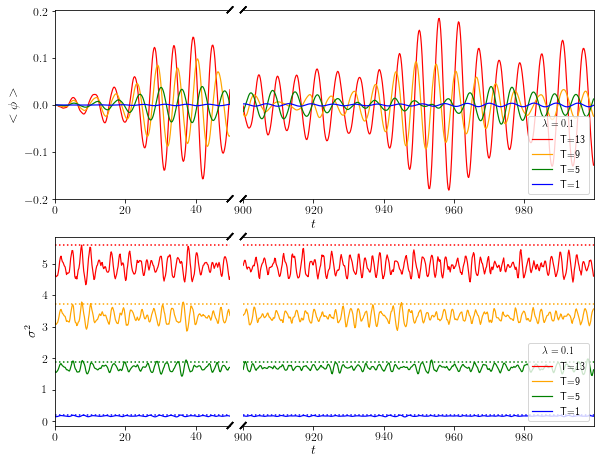

$\lambda = $0.1 $\gamma = $1


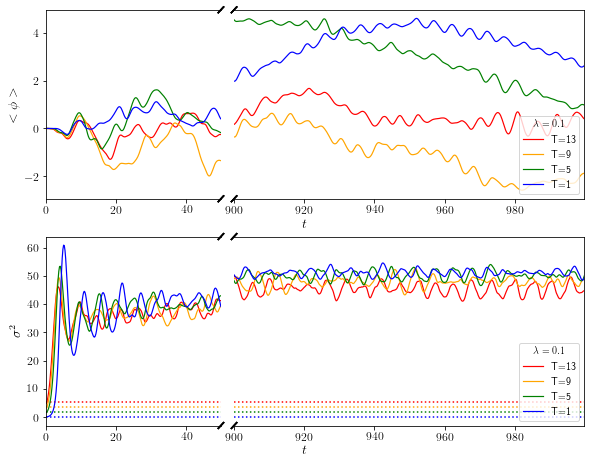

$\lambda = $1 $\gamma = $0


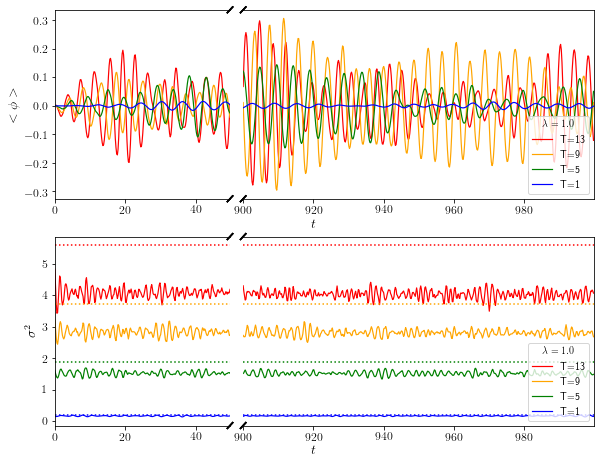

$\lambda = $1 $\gamma = $1


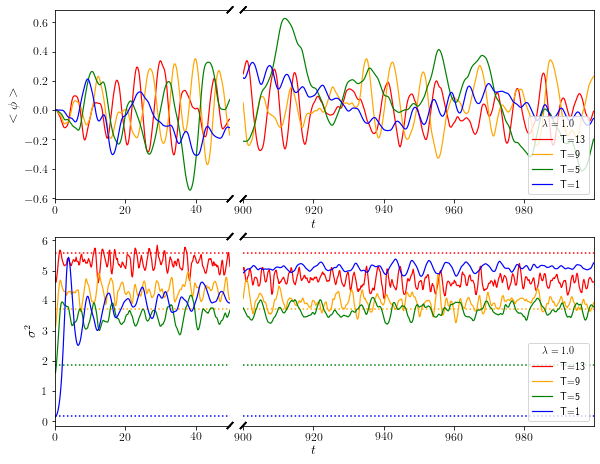

$\lambda = $10 $\gamma = $0


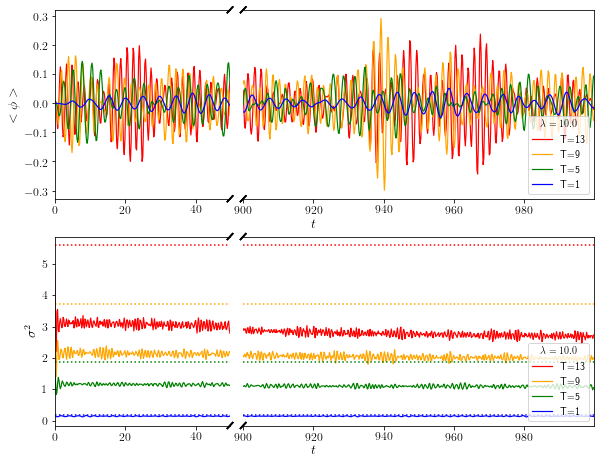

$\lambda = $10 $\gamma = $1


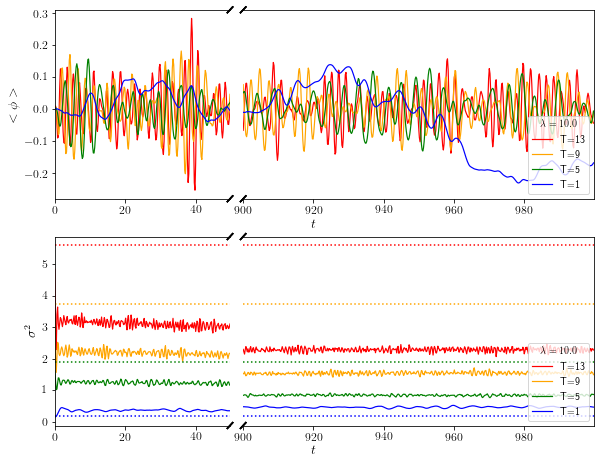

In [138]:
for lll, lamb in enumerate(list_lamb):
    for ggg, gamma in enumerate(list_gamma):
        print(r'$\lambda = $'+str(lamb), r'$\gamma = $'+str(gamma))

        fig, ax = plt.subplots(2, 2, figsize=(10, 7), sharey=False, gridspec_kw={'width_ratios': [1,2]})
        plt.subplots_adjust(wspace=0.05)

        colors = cycle(('r', 'orange', 'g', 'b', 'purple'))
        lsvec = ['-', ':']
 #       for ttt, temp in enumerate(list_temp):
        for temp in list_temp[::-1]:
            ttt = list_temp.tolist().index(temp)
            colr = next(colors)
            for ind, data in enumerate(all_data):
                current_data = data[ttt][lll][ggg]
                list_time = np.arange(np.shape(current_data[0][0])[0])
                mnfld = [np.mean(current_data[:,0,time]) for time in list_time]
                list_sigma0 = [np.mean(current_data[:,0,time]**2.) for time in list_time]
                list_time2print = np.asarray(np.arange(nLat//2).tolist() + np.arange(nTime*nTimemultiplier2-nLat, nTime*nTimemultiplier2).tolist())*dtout
                
                for row, axx in enumerate(ax):
                    for col, axxx in enumerate(axx):
                        if row == 0:
                            if col == 0:
                                axxx.plot(list_time2print, mnfld, color=colr, alpha=1, linewidth=1.2)
                            else:
                                axxx.plot(list_time2print, mnfld, color=colr, label='T='+str(temp), alpha=1, linewidth=1.2)
                        else:
                            if col == 0:
                                axxx.plot(list_time2print, list_sigma0, color=colr, alpha=1, linewidth=1.2)
                                axxx.axhline(sigma0sq_th(m2bare, temp), linestyle=':', color=colr)
                            else:
                                axxx.plot(list_time2print, list_sigma0, color=colr, label='T='+str(temp), alpha=1, linewidth=1.2)
                                axxx.axhline(sigma0sq_th(m2bare, temp), linestyle=':', color=colr)
                d = .015
                for row, axx in enumerate(ax):
                    for col, axxx in enumerate(axx):
                        if row == 0 and col == 0:
                            kwargs = dict(transform=axxx.transAxes, color='k', clip_on=False)
                        else:
                            kwargs.update(transform=axxx.transAxes)

                        if col == 0:
                            axxx.set_xlim(-1,list_time2print[nLat//2-1])
                            axxx.spines['right'].set_visible(False)
                            axxx.yaxis.tick_left()
                            axxx.plot((1-d,1+d),(-d,+d), **kwargs)
                            axxx.plot((1-d,1+d),(1-d,1+d), **kwargs)
                            
                            if row == 0:
                                axxx.set_ylabel(r'$<\phi>$')
                            else:
                                axxx.set_ylabel(r'$\sigma^2$')
                        else:
                            axxx.spines['left'].set_visible(False)
                            axxx.yaxis.set_visible(False)
                            axxx.set_xlim(list_time2print[nLat//2], list_time2print[-1]+1)
                            axxx.legend(title=r'$\lambda = %5.1f$'%(lamb), loc='lower right')
                            axxx.plot((-d/2,d/2),(-d,+d), **kwargs)
                            axxx.plot((-d/2,d/2),(1-d,1+d), **kwargs)
                            
                            axxx.set_xlabel(r'$t$')
                            axxx.xaxis.set_label_coords(0.2, -0.1)

        plt.show()

In [1]:
if False:
    sim = random.randint(0, nSims-1)

    for lll, lamb in enumerate(list_lamb):
        for ggg, gamma in enumerate(list_gamma):
            if ggg == 0:
                continue
            for ind, data in enumerate(all_data):
                print('ind = '+str(ind), r'$\lambda = $'+str(lamb), r'$\gamma = $'+str(gamma))
                fig, ax = plt.subplots(1, len(list_temp), figsize = (4*len(list_temp), 3.5))
                for ttt, temp in enumerate(list_temp):
                    exts = [0, lenLat, 0, int(nTime*nTimemultiplier2*dtout)]
                    ax[ttt].axhline(nTime*nTimemultiplier2*dtout//3, color='darkgray', ls='--')
                    ax[ttt].locator_params(axis="y", nbins=1)
#                    ax[ttt].yaxis.set_ticks([])
#                    ax[ttt].yaxis.set_ticklabels([])
                    ax[ttt].set_yticklabels([0, int(nTime*nTimemultiplier2*dtout)])
#                    ax[ttt].set_yticklabels([0, str(int(nLat//2*dtout))+'='+str(int((nTime*nTimemultiplier2-nLat)*dtout)),  int((nTime*nTimemultiplier2-nLat//2)*dtout), int(nTime*nTimemultiplier2*dtout)])
                    im0 = ax[ttt].imshow(data[ttt][lll][ggg][sim][0], aspect='auto', interpolation='none', origin='lower', extent=exts)
                    clb = plt.colorbar(im0, ax = ax[ttt])
                    clb.set_label(r'$\phi(t,x)$')
                    ax[ttt].set_xlabel(r'$x$')
                    ax[ttt].set_ylabel(r'$t$')
                    ax[ttt].legend(title=r'$T = %5.0f, \lambda = %5.1f$'%(temp, lamb))
                plt.tight_layout()
                plt.show()

In [12]:
print(np.shape(all_data))
all_data = all_data[:,:,:,:,:,:,-nLat:]
print(np.shape(all_data))

(1, 4, 3, 2, 2, 2, 1024, 512)
(1, 4, 3, 2, 2, 2, 512, 512)


In [2]:
if False:
    sim = random.randint(0, nSims-1)

    for lll, lamb in enumerate(list_lamb):
        for ggg, gamma in enumerate(list_gamma):
            for ind, data in enumerate(all_data):
                print('ind = '+str(ind), r'$\lambda = $'+str(lamb), r'$\gamma = $'+str(gamma))
                fig, ax = plt.subplots(1, len(list_temp), figsize = (4*len(list_temp), 3.5))
                for ttt, temp in enumerate(list_temp):
                    nTT = nTime*(nTimemultiplier1 if gamma != 1 else nTimemultiplier2)
                    ext = [0, lenLat, (nTT-nLat)*dtout, nTT*dtout]
                    im0 = ax[ttt].imshow(data[ttt][lll][ggg][sim][0], aspect='auto', interpolation='none', origin='lower', extent=ext)
                    clb = plt.colorbar(im0, ax = ax[ttt])
                    clb.set_label(r'$\phi(t,x)$')
                    ax[ttt].set_xlabel(r'$x$')
                    ax[ttt].set_ylabel(r'$t$')
                    ax[ttt].legend(title=r'$T = %5.0f, \lambda = %5.1f$'%(temp, lamb))
                plt.tight_layout()
                plt.show()

In [ ]:
if False:
    for lll, lamb in enumerate(list_lamb):
        print(r'$\lambda = $'+str(lamb))
        for ggg, gamma in enumerate(list_gamma):
            print(r'$\gamma = $'+str(gamma))
            print([sigma0sq_th(m2bare, temp) for temp in list_temp])
            for ind, data in enumerate(all_data):
                print([np.mean([np.mean(data[ttt][lll][ggg][sim][0][0]**2.) for sim in range(nSims)], axis=0) for ttt in range(len(list_temp))])

In [15]:
def get_pspec(current_data, thresh):
    PowSpec = np.mean([np.abs(np.fft.fftshift(np.fft.ifft2(current_data[sim][0])))**2. for sim in range(nSims)], axis=0)
    kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi

    pick_freq_window = (kk>0)&(kk<thresh)
#    print('averaged ks', kk[kk==pick_freq_window])
    pick_omega = np.sort(oo[oo>0])[0]
    return PowSpec, np.mean(PowSpec[:, kk==pick_freq_window], axis=1)[(np.in1d(oo,kk))&(oo>0)], PowSpec[oo==pick_omega, kk>0], oo[oo>0], kk[kk>0]

def get_3pspec(current_data, thresh):
    fullPowSpec, rePowSpec, imPowSpec = [], [], []
    for sim in range(nSims):
        fftfield = np.fft.fftshift(np.fft.ifft2(current_data[sim][0]))
        fullPowSpec.append(np.abs(fftfield)**2.)
        rePowSpec.append(np.abs(fftfield.real)**2.)
        imPowSpec.append(np.abs(fftfield.imag)**2.)
    list_PowSpec = [np.mean(fullPowSpec, axis = 0), np.mean(rePowSpec, axis = 0), np.mean(imPowSpec, axis = 0)]
    T, N = np.shape(list_PowSpec[0])
    kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi

    pick_freq_window = (kk>0)&(kk<thresh)
#    print('averaged ks', kk[kk==pick_freq_window])
    pick_omega = np.sort(oo[oo>0])[0]
    return [[PowSpec, np.mean(PowSpec[:, kk==pick_freq_window], axis=1)[(np.in1d(oo,kk))&(oo>0)], PowSpec[oo==pick_omega, kk>0], oo[oo>0], kk[kk>0]] for PowSpec in list_PowSpec]

def get_truncation_frequency(PowSpec, thresh):
    kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi
    pick_freq_window = (kk>0)&(kk<thresh)
    window_in_k = np.mean(PowSpec[:, kk==pick_freq_window], axis=1)[(oo>0)&(oo<=max(kk))] # here oo becomes kk
    minpeaks, properties = scs.find_peaks(-window_in_k, height=-max(window_in_k))
    try:
        if window_in_k[1]-window_in_k[0]>0: # basically here there are no walls, the PS is scrictly ascending at low k
            raise ValueError
        peak = minpeaks[0]
        height = -properties['peak_heights'][minpeaks==peak][0]
    except (ValueError, IndexError):
        peak = 0
        height = window_in_k[peak]
    return [peak, height]

#def get_truncation_frequency(PowSpec, thresh):
#    kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
#    oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi
##    kselect1 = np.sort(kk[kk>0])[0]
##    window_in_k1 = np.mean(PowSpec[:, kk==kselect1], axis=1)[(np.in1d(oo,kk))&(oo>0)]
#    pick_freq_window = (kk>0)&(kk<thresh)
#    window_in_k = np.mean(PowSpec[:, kk==pick_freq_window], axis=1)[(np.in1d(oo,kk))&(oo>0)]
#    smooth_window_in_k = gaussian_filter1d(window_in_k, sigma=0.8, mode='constant')
#    try:
#        minpeaks, properties = scs.find_peaks(-smooth_window_in_k, height=-max(smooth_window_in_k))
#        minpeaks, height = minpeaks[0], -properties['peak_heights'][0]
#        maxpeaks, properties = scs.find_peaks(smooth_window_in_k, height=min(smooth_window_in_k))
#        if minpeaks < maxpeaks[properties['peak_heights']==max(properties['peak_heights'])]:
#            return [minpeaks, height]
#        else:
##            print('ValueError')
#            raise ValueError
#    except (ValueError, IndexError):
##        print('IndexError')
#        minpeaks = 0
#        height = smooth_window_in_k[minpeaks]
#        return [minpeaks, height]

In [16]:
def get_masses(ind, data, bool, bool2, multiplier, lll, lamb, ggg, gamma, thresh):
    masses = []
    minima, maxima, curvs = curvatures(lamb, gamma)
    if bool2: fig, ax = plt.subplots(1, len(list_temp), figsize = (6*len(list_temp), 4))
    
    for ttt, temp in enumerate(list_temp):
        PowSpec = np.mean(np.abs(np.fft.fftshift(np.fft.ifft2(data[ttt][lll][ggg][:,0])))**2., axis=0)
        PowSpec2plot = PowSpec

        kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
        oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi
        KK, OO = np.meshgrid(kk,oo)
        
        if gamma == 0:
            osccoords = np.argwhere(PowSpec > np.mean(PowSpec) + multiplier * np.std(PowSpec))
        else:
            trunc_freq, trunc_amp = get_truncation_frequency(PowSpec, thresh)
            PowSpec = PowSpec*(np.abs(OO) >= oo[oo>0][trunc_freq])
            osccoords = np.argwhere(PowSpec > min(trunc_amp, np.mean(PowSpec) + multiplier * np.std(PowSpec) ))

        popt, pcov = sco.curve_fit(omega_fit, kk[osccoords[:,1]], oo[osccoords[:,0]]**2.)
        if popt[-1] < 0: masses.append('nan')
        else: masses.append(popt[-1])

        if bool2:
            lim = 5
            kk2plot = kk[(0<=kk)&(kk<=lim)]
            oo2plot = oo[(0<=oo)&(oo<=lim)]
            PowSpec2plot = PowSpec2plot[:, (0<=kk)&(kk<=lim)][(0<=oo)&(oo<=lim)]

            [ax[ttt].plot(kk, np.sqrt(omega_fit(kk, curv_eg)), color = 'purple', ls=':', label=r'$V(\phi)^{\prime\prime} = %5.2f$'%(curv_eg)) for curv_eg in np.abs(curvs[0][:1])]
            [ax[ttt].plot(kk, np.sqrt(omega_fit(kk, curv_eg)), color = 'r', ls=':', label=r'$V(\phi)^{\prime\prime} = %5.2f$'%(curv_eg)) for curv_eg in np.abs(curvs[1][:1])]
            ax[ttt].plot(kk, np.sqrt(omega_fit(kk,*popt)), color = 'orange', ls='-', label=f'$m^2 = %5.2f$'%(popt[-1]))
            
            exts = [kk2plot[0],kk2plot[-1],oo2plot[0],oo2plot[-1]]
            im = ax[ttt].imshow(np.log(np.sqrt(PowSpec2plot)), aspect='auto', interpolation='none', origin='lower', extent=exts)
            clb = plt.colorbar(im, ax = ax[ttt])
            clb.set_label(r'$\log{\sqrt{|\phi_k|^2}}$')
            ax[ttt].set_xlabel(r'$\bar{k}$')
            ax[ttt].set_ylabel(r'$\bar{\omega_k}$')
            [axx.set_xlim(0,kk2plot[-1]) for axx in ax]
            [axx.set_ylim(0,oo2plot[-1]) for axx in ax]
            ax[ttt].legend(title=r'$T = %5.0f, \lambda = %5.1f$'%(temp, lamb))
            
        if bool:
            lim = max(freqs)
            fig, ax = plt.subplots(1, 2, figsize = (16, 4))
            kk2plot = kk[(0<=kk)&(kk<=lim)]
            oo2plot = oo[(0<=oo)&(oo<=lim)]
            ax[0].plot(kk[osccoords[:,1]], oo[osccoords[:,0]], 'o', ms=5, label='freqs')
            ax[0].plot(kk, np.sqrt(omega_fit(kk,*popt)), label=f'$T = %5.5f, m^2 = %5.5f$'%(temp, popt[-1]))
            ax[0].set_xlim(0,kk2plot[-1])
            ax[0].set_ylim(0,oo2plot[-1])
            ax[0].axhline(popt[-1], color='darkgray', ls=':', label='best fit')
            ax[0].axhline(m2bare, color='darkgray', ls='-.', label='potential mass')
            ax[0].legend()

            lim = 3
            kk2plot = kk[(0<=kk)&(kk<=lim)]
            oo2plot = oo[(0<=oo)&(oo<=lim)]
            PowSpec2plot = PowSpec2plot[:, (0<=kk)&(kk<=lim)][(0<=oo)&(oo<=lim)]
            ax[1].plot(kk, np.sqrt(omega_fit(kk,*popt)), color = 'y', ls=':', label=f'$m^2 = %5.2f$'%(popt[-1]))
            [ax[1].plot(kk, np.sqrt(omega_fit(kk, curv_eg)), color = 'purple', ls=':', label=r'$V(\phi)^{\prime\prime} = %5.2f$'%(curv_eg)) for curv_eg in np.abs(curvs[0][:1])]
            [ax[1].plot(kk, np.sqrt(omega_fit(kk, curv_eg)), color = 'r', ls=':', label=r'$V(\phi)^{\prime\prime} = %5.2f$'%(curv_eg)) for curv_eg in np.abs(curvs[1][:1])]
            exts = [kk2plot[0],kk2plot[-1],oo2plot[0],oo2plot[-1]]
            im = ax[1].imshow(np.log(PowSpec2plot), aspect='auto', interpolation='none', origin='lower', extent=exts)
            clb = plt.colorbar(im, ax = ax[1])
            clb.set_label(r'$\log{\sqrt{|\phi_k|^2}}$')
            ax[1].set_xlabel(r'$\bar{k}$')
            ax[1].set_ylabel(r'$\bar{\omega_k}$')
            ax[1].set_xlim(0,kk2plot[-1])
            ax[1].set_ylim(0,oo2plot[-1])
            [i.legend(r'$T = %5.0f, \lambda = %5.1f$'%(temp, lamb)) for i in ax]
            plt.show()
    return masses

In [ ]:
multiplier = 10
thresh = 0.1

disp_masses = [[[get_masses(ind, data, False, False, multiplier, lll, lamb, ggg, gamma, thresh) for ggg,gamma in enumerate(list_gamma)] for lll, lamb in enumerate(list_lamb)] for ind, data in enumerate(all_data)]
print(np.shape(disp_masses))

fig, ax = plt.subplots(len(list_lamb), len(list_gamma), figsize = (15,8), sharex=True)
plt.subplots_adjust(hspace=0)

list_fine_temp = np.linspace(0.01, max(list_temp), 1000)
lsvec = ['-', ':']
for ggg, gamma in enumerate(list_gamma):
    for lll, lamb in enumerate(list_lamb):

        ax[lll][ggg].plot(list_fine_temp, np.abs((m2bare if gamma==0 else -m2bare) + 0.5*lamb*sigma0sq_th(m2bare, list_fine_temp)), color='blue', linestyle='-', label='prediction from PS')
        [ax[lll][ggg].plot(list_temp, dispersion_mass[lll][ggg], color='green', marker='o', linestyle='--', label=r'$m^2_{eff}$') for dispersion_mass in disp_masses]

        ax[lll][ggg].set_ylabel(r'$m_{eff}^2$')
        ax[lll][ggg].legend(title=r'$\lambda = %5.1f$'%(lamb), loc='upper left')
        [o.grid(color='darkgray', linestyle='-', linewidth=0.2) for o in ax[lll]]
    ax[-1][ggg].set_xlabel(f'$Temperature$')
plt.show()

In [3]:
# Compare PS vs omega for m2ps = m2bare and m2ps = m2eff gaussian first order summation

if False:
    for ggg, gamma in enumerate(list_gamma):
        for lll, lamb in enumerate(list_lamb):
            fig, ax = plt.subplots(1, 1, figsize = (10, 5))
            lsvec = ['--', ':']
            for ind, data in enumerate(all_data):
                colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
                data_mass = get_masses(ind, data, False, False, multiplier, lll, lamb, ggg, gamma, thresh)

                for ttt, temp in enumerate(list_temp):
                    col = next(colors)

                    pspec, window_in_k, fix_omega, oo, kk = get_pspec(data[ttt][lll][ggg], thresh)
                    peak, height = get_truncation_frequency(pspec, thresh)
     #               plt.plot(kk[peak]**2., height, "*", color=col, ms=10, alpha=0.5)

                    plt.plot(kk[kk>0]**2., window_in_k, ls='-', label=f'$T$ = '+str(temp), color=col)
                    plt.axvline(data_mass[ttt], color=col, ls=lsvec[ind], label='$m^2 = %5.2f$'%data_mass[ttt])

    #                m2_from_PS = np.abs((m2bare if gamma==0 else -m2bare) + 0.5*lamb*sigma0sq_th(m2bare, temp))
    #                time = -1
    #                m2_from_RMS_time = np.abs((m2bare if gamma==0 else -m2bare) + 0.5*lamb*np.mean([data[ttt][lll][ggg][sim][0][time]**2. for sim in range(nSims)]))
        #            plt.axvline(m2_from_PS, color=col, linestyle='-', label='from th PS $m^2 = %5.2f$'%m2_from_PS)
        #            plt.axvline(m2_from_RMS_time, color=col, linestyle='--', label='at $t=t_f$, $m^2 = %5.2f$'%m2_from_RMS_time)

                    plt.xlabel(f'$\omega_k^2$')
                plt.xscale('log')
                plt.yscale('log')

            plt.ylabel(f'$PS(\phi)$')
            plt.grid(color='darkgray', linestyle='-', linewidth=0.2)
            plt.legend(title=r'$\lambda = %5.1f, \gamma = %5.0f$'%(lamb, gamma))
            plt.tight_layout()
            plt.show()

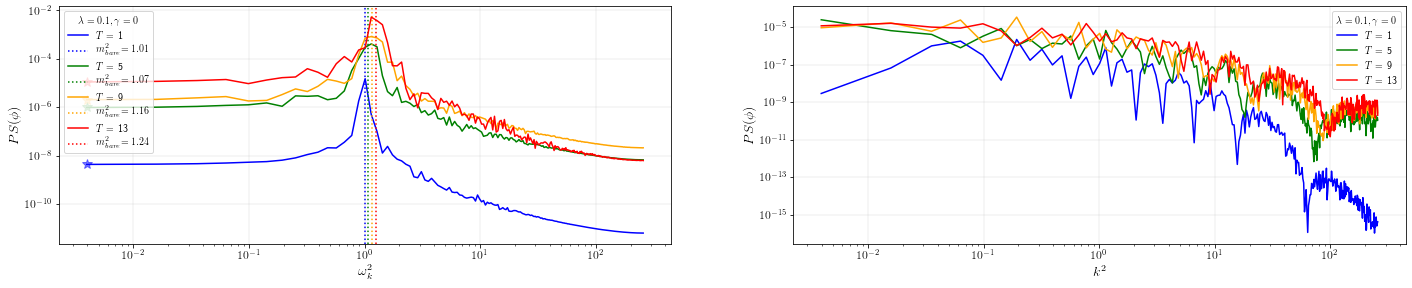

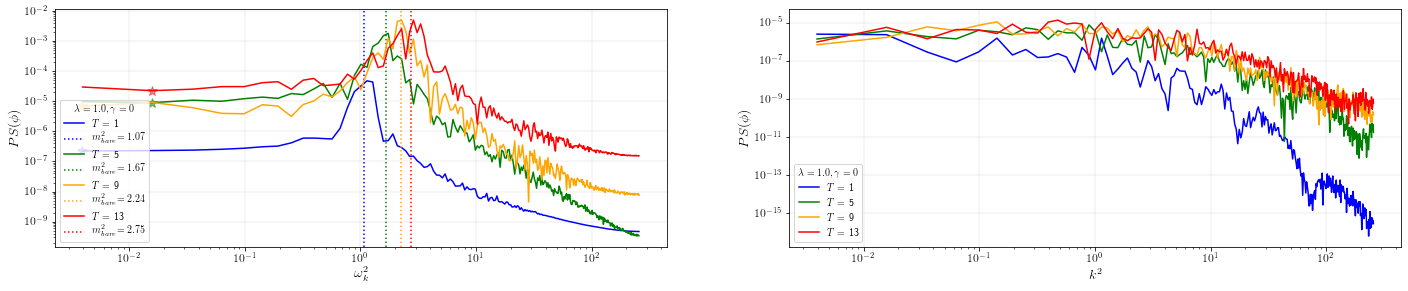

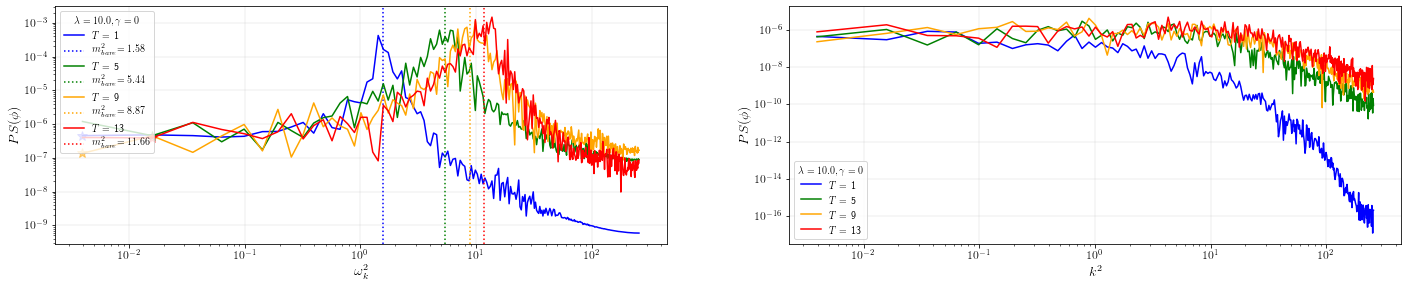

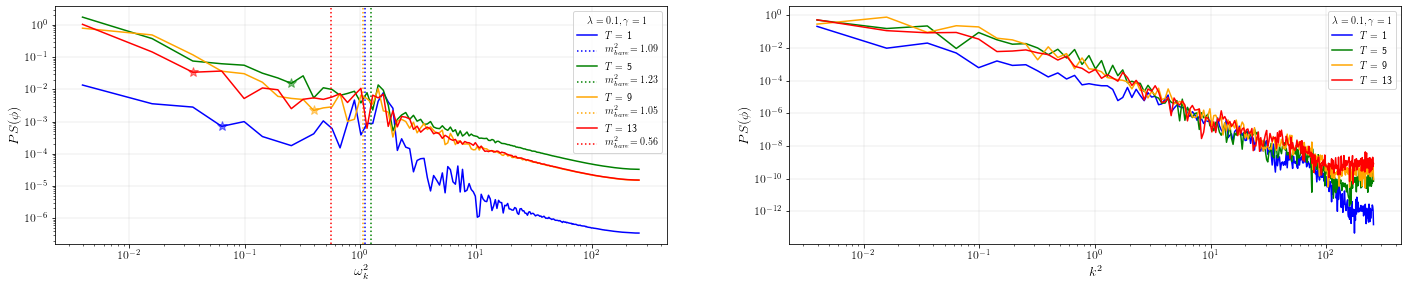

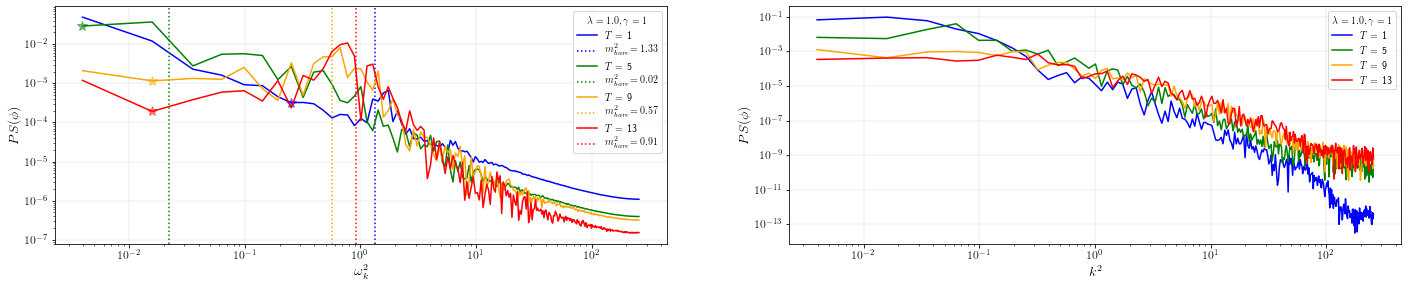

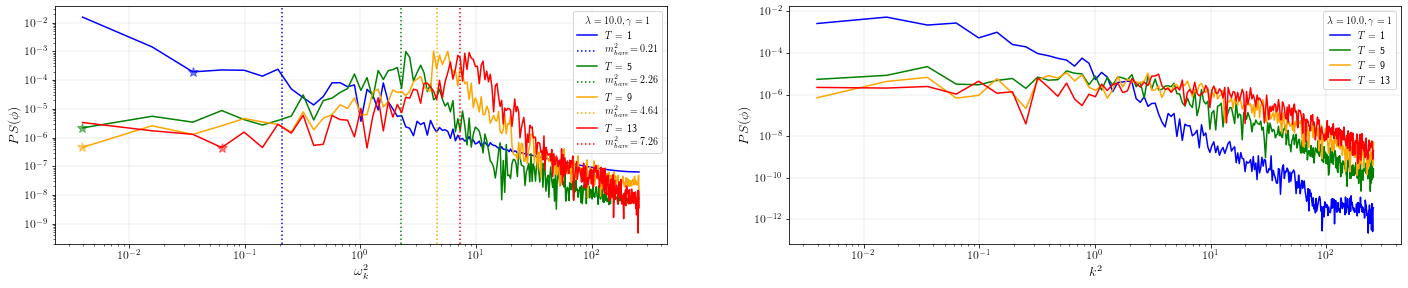

In [19]:
# Compare PS vs omega and PS vs k for m2ps = m2bare and m2ps = m2eff gaussian first order summation

for ggg, gamma in enumerate(list_gamma):
    for lll, lamb in enumerate(list_lamb):
        data_mass = [get_masses(ind, data, False, False, multiplier, lll, lamb, ggg, gamma, thresh) for ind, data in enumerate(all_data)]
        colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
        titles = [r'$m^2_{bare}$', r'$m^2_{eff}$']
        lsvec = ['-', ':']

        fig, ax = plt.subplots(1, 2, figsize = (25, 4))
        for ttt, temp in enumerate(list_temp):
            col = next(colors)

            for ind, data in enumerate(all_data):
                pspec, window_in_k, fix_omega, oo, kk = get_pspec(data[ttt][lll][ggg], thresh)
                peak, height = get_truncation_frequency(pspec, thresh)
                ax[0].plot(kk[peak]**2., height, "*", color=col, ms=10, alpha=0.5)

                ax[0].plot(kk**2., window_in_k, label=f'$T$ = '+str(temp), color=col, ls=lsvec[ind])
                ax[1].plot(kk**2., fix_omega, label=f'$T$ = '+str(temp), color=col, ls=lsvec[ind])

                ax[0].axvline(data_mass[ind][ttt], color=col, ls=':', label=titles[ind]+'$ = %5.2f$'%data_mass[ind][ttt])

        ax[0].set_xlabel(f'$\omega_k^2$')
        ax[1].set_xlabel(f'$k^2$')

        for axx in ax:
            axx.set_xscale('log')
            axx.set_yscale('log')
            axx.set_ylabel(f'$PS(\phi)$')
    #        axx.legend(bbox_to_anchor=(1.04,0.5), loc="center left", title=f'$\lambda = %5.2f$'%(lamb))
            axx.legend(title=r'$\lambda = %5.1f, \gamma = %5.0f$'%(lamb, gamma))
            axx.grid(color='darkgray', linestyle='-', linewidth=0.2)        
        plt.show()

In [27]:
def get_masses_seps(ind, data, bool, multiplier, lll, lamb, ggg, gamma, thresh):
    fullmasses, remasses, immasses = [], [], []
    for ttt, temp in enumerate(list_temp):
        fullPowSpec, rePowSpec, imPowSpec = [], [], []
        for sim in range(nSims):
            fftfield = np.fft.fftshift(np.fft.ifft2(data[ttt][lll][ggg][sim][0]))
            fullPowSpec.append(np.abs(fftfield)**2.)
            rePowSpec.append(np.abs(fftfield.real)**2.)
            imPowSpec.append(np.abs(fftfield.imag)**2.)
        fullPowSpec, rePowSpec, imPowSpec = np.mean(fullPowSpec, axis = 0), np.mean(rePowSpec, axis = 0), np.mean(imPowSpec, axis = 0)
        fullPowSpec2plot, rePowSpec2plot, imPowSpec2plot = fullPowSpec, rePowSpec, imPowSpec
        
        T, N = np.shape(fullPowSpec)
        kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
        oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi
        KK, OO = np.meshgrid(kk,oo)

        full_trunc_freq, full_trunc_amp = get_truncation_frequency(fullPowSpec, thresh)
        re_trunc_freq, re_trunc_amp = get_truncation_frequency(rePowSpec, thresh)
        im_trunc_freq, im_trunc_amp = get_truncation_frequency(imPowSpec, thresh)

        fullPowSpec = fullPowSpec*(np.abs(OO) >= oo[oo>0][full_trunc_freq])
        rePowSpec = rePowSpec*(np.abs(OO) >= oo[oo>0][re_trunc_freq])
        imPowSpec = imPowSpec*(np.abs(OO) >= oo[oo>0][im_trunc_freq])

        if ind == 0:
            fullosccoords = np.argwhere(fullPowSpec > max(full_trunc_amp, np.mean(fullPowSpec) + multiplier * np.std(fullPowSpec)))
            reosccoords = np.argwhere(rePowSpec > max(re_trunc_amp, np.mean(rePowSpec) + multiplier * np.std(rePowSpec)))
            imosccoords = np.argwhere(imPowSpec > max(im_trunc_amp, np.mean(imPowSpec) + multiplier * np.std(imPowSpec)))
        else:
            fullosccoords = np.argwhere(fullPowSpec > min(full_trunc_amp, np.mean(fullPowSpec) + multiplier * np.std(fullPowSpec)))
            reosccoords = np.argwhere(rePowSpec > min(re_trunc_amp, np.mean(rePowSpec) + multiplier * np.std(rePowSpec)))
            imosccoords = np.argwhere(imPowSpec > min(im_trunc_amp, np.mean(imPowSpec) + multiplier * np.std(imPowSpec)))            

        fullmasses.append(sco.curve_fit(omega_fit, kk[fullosccoords[:,1]], oo[fullosccoords[:,0]]**2.)[0])
        remasses.append(sco.curve_fit(omega_fit, kk[reosccoords[:,1]], oo[reosccoords[:,0]]**2.)[0])
        immasses.append(sco.curve_fit(omega_fit, kk[imosccoords[:,1]], oo[imosccoords[:,0]]**2.)[0])

        coords = np.asarray([fullosccoords, reosccoords, imosccoords])
        PowSpecs2Plot = np.asarray([fullPowSpec2plot, rePowSpec2plot, imPowSpec2plot])
        allMasses = np.asarray([fullmasses, remasses, immasses])
        
        title = ['Full, ', 'Real, ', 'Imag, ']
        if bool:
            fig, ax = plt.subplots(1, len(allMasses), figsize = (20, 4))
            for iii, masses in enumerate(allMasses):
                lim = 5
                kk2plot = kk[(0<=kk)&(kk<=lim)]
                oo2plot = oo[(0<=oo)&(oo<=lim)]
                powspec2plot = PowSpecs2Plot[iii][:, (0<=kk)&(kk<=lim)][(0<=oo)&(oo<=lim)]

                ax[iii].plot(kk[coords[iii][:,1]], oo[coords[iii][:,0]], 'o', ms=5)
                ax[iii].plot(kk, np.sqrt(omega_fit(kk,masses[-1])), color = 'r', linestyle=':', label=f'$m^2 = %5.2f$'%(masses[-1]))
                exts = [kk2plot[0],kk2plot[-1],oo2plot[0],oo2plot[-1]]
                im = ax[iii].imshow(np.log(np.sqrt(powspec2plot)), aspect='auto', interpolation='none', origin='lower', extent=exts)
                clb = plt.colorbar(im, ax = ax[iii])
                clb.set_label(r'$\log{\sqrt{|\phi_k|^2}}$')

            for opp in ax:
                opp.set_xlabel(r'$\bar{k}$')
                opp.set_ylabel(r'$\bar{\omega_k}$')
                opp.set_xlim(0,kk2plot[-1])
                opp.set_ylim(0,oo2plot[-1])
                opp.legend(title=r'$T = %5.0f, \lambda = %5.1f$'%(temp, lamb), loc='upper center')
            plt.show()
    return allMasses

In [4]:
title = ['Full, ', 'Real, ', 'Imag, ']

if False:
    for ggg, gamma in enumerate(list_gamma):
        for lll, lamb in enumerate(list_lamb):
            data_mass = get_masses_seps(ind, data, False, multiplier, lll, lamb, ggg, gamma, thresh)

            colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
            fig, ax = plt.subplots(1, 2, figsize = (20, 5))
            for ttt, temp in enumerate(list_temp):
                col = next(colors)

                powspec_info = get_3pspec(data[ttt][lll][ggg], thresh)
                lsvec = ['-', '--', ':']

                for iii, PowSpec in enumerate(powspec_info):
                    pspec, window_in_k, fix_omega, oo, kk = PowSpec
                    peak, height = get_truncation_frequency(pspec, thresh)
         #           ax[0].plot(kk[peak]**2., height, "*", color=col, ms=10, alpha=0.5)

                    if iii == 0:
                        ax[0].plot(kk**2., window_in_k, color=col, ls=lsvec[iii], label=f'$T$ = '+str(temp))
                        ax[1].plot(kk**2., fix_omega, color=col, ls=lsvec[iii], label=f'$T$ = '+str(temp))
                    else:
                        ax[0].plot(kk**2., window_in_k, color=col, ls=lsvec[iii])
                        ax[1].plot(kk**2., fix_omega, color=col, ls=lsvec[iii])
        #            ax[0].axvline(data_mass[iii][ttt], color=col, ls=lsvec[ind], label=title[iii]+r', $m^2 = %5.2f$'%data_mass[iii][ttt])
                ax[0].axvline(data_mass[0][ttt], color=col, ls=':', label=r'$m^2 = %5.2f$'%data_mass[iii][ttt])

            ax[0].set_xlabel(f'$\omega_k^2$')
            ax[1].set_xlabel(f'$k^2$')

            for axx in ax:
                axx.set_xscale('log')
                axx.set_yscale('log')
                axx.set_ylabel(f'$PS(\phi)$')
                axx.grid(color='darkgray', linestyle='-', linewidth=0.2)
                axx.legend(title=r'$\lambda = %5.1f$'%(lamb))
            plt.tight_layout()
            plt.show()

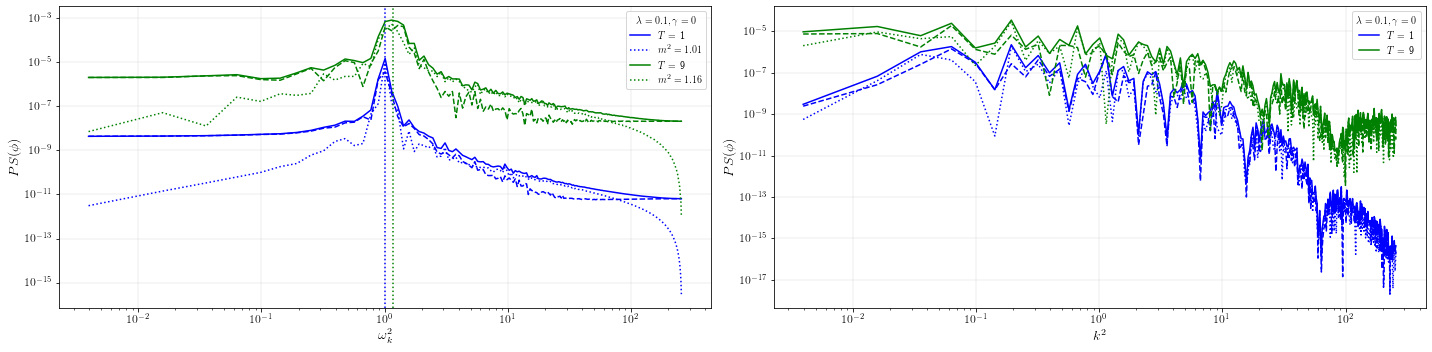

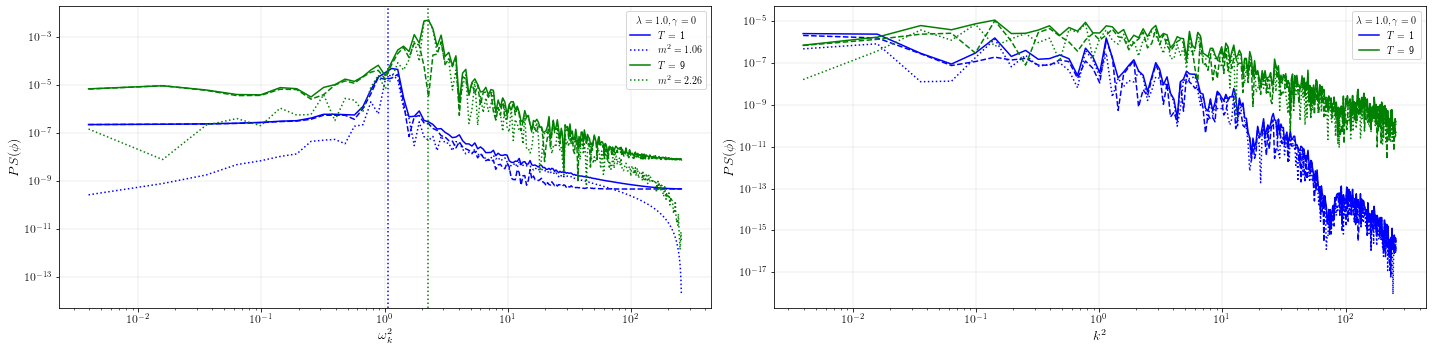

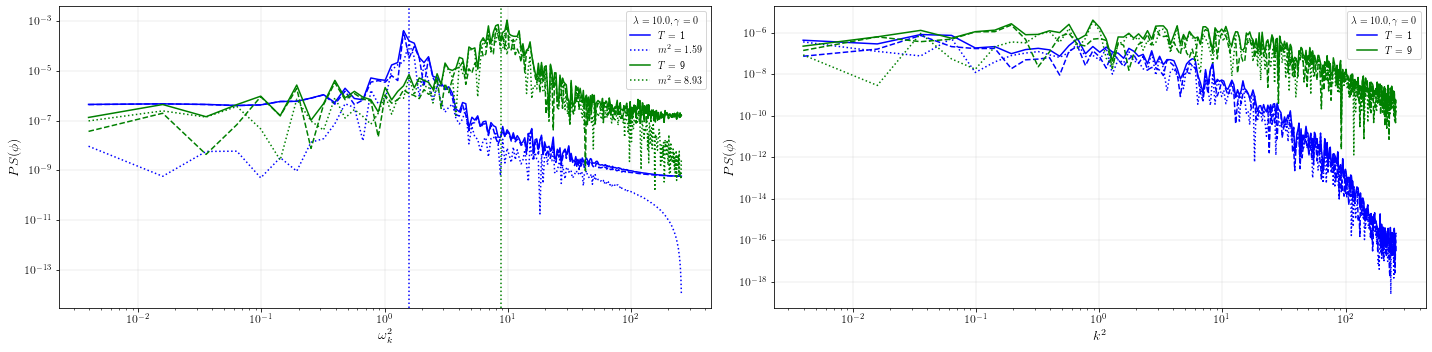

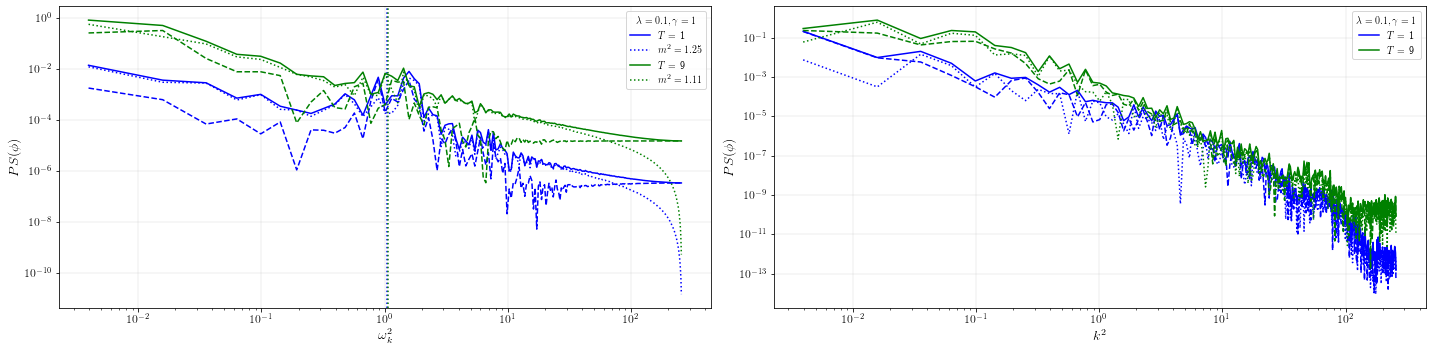

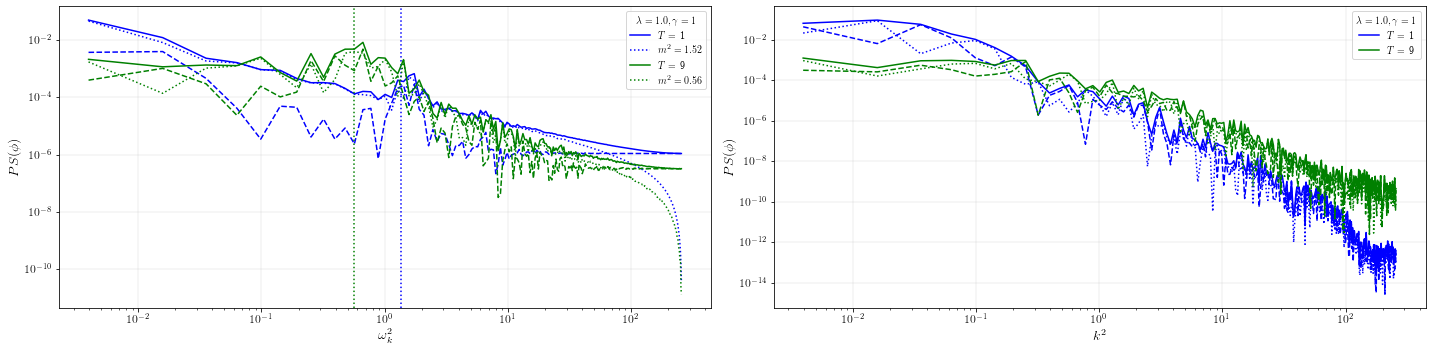

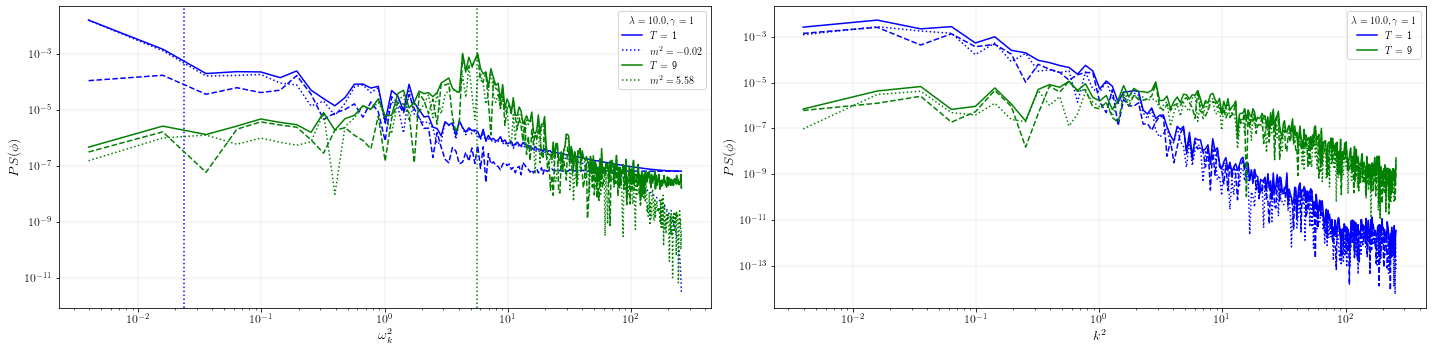

In [22]:
title = ['Full, ', 'Real, ', 'Imag, ']
for ggg, gamma in enumerate(list_gamma):
    for lll, lamb in enumerate(list_lamb):
        data_mass = get_masses_seps(ind, data, False, multiplier, lll, lamb, ggg, gamma, thresh)

        colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
        fig, ax = plt.subplots(1, 2, figsize = (20, 5))
        for ttt, temp in enumerate(list_temp):
            if ttt%2==1:
                continue
            col = next(colors)

            powspec_info = get_3pspec(data[ttt][lll][ggg], thresh)
            lsvec = ['-', '--', ':']
            for iii, PowSpec in enumerate(powspec_info):
                pspec, window_in_k, fix_omega, oo, kk = PowSpec
                peak, height = get_truncation_frequency(pspec, thresh)
               # ax[0].plot(kk[peak]**2., height, "*", color=col, ms=10, alpha=0.5)

                if iii == 0:
                    ax[0].plot(kk**2., window_in_k, color=col, ls=lsvec[iii], label=f'$T$ = '+str(temp))
                    ax[1].plot(kk**2., fix_omega, color=col, ls=lsvec[iii], label=f'$T$ = '+str(temp))
                else:
                    ax[0].plot(kk**2., window_in_k, color=col, ls=lsvec[iii])
                    ax[1].plot(kk**2., fix_omega, color=col, ls=lsvec[iii])
            ax[0].axvline(data_mass[0][ttt], color=col, ls=':', label=r'$m^2 = %5.2f$'%data_mass[iii][ttt])

        ax[0].set_xlabel(f'$\omega_k^2$')
        ax[1].set_xlabel(f'$k^2$')

        for axx in ax:
            axx.set_xscale('log')
            axx.set_yscale('log')
            axx.set_ylabel(f'$PS(\phi)$')
            axx.grid(color='darkgray', linestyle='-', linewidth=0.2)
            axx.legend(title=r'$\lambda = %5.1f, \gamma = %5.0f$'%(lamb, gamma))
        plt.tight_layout()
        plt.show()

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


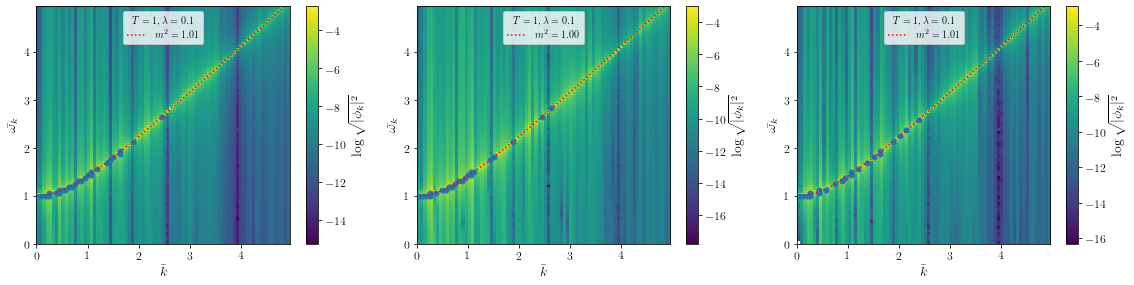

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


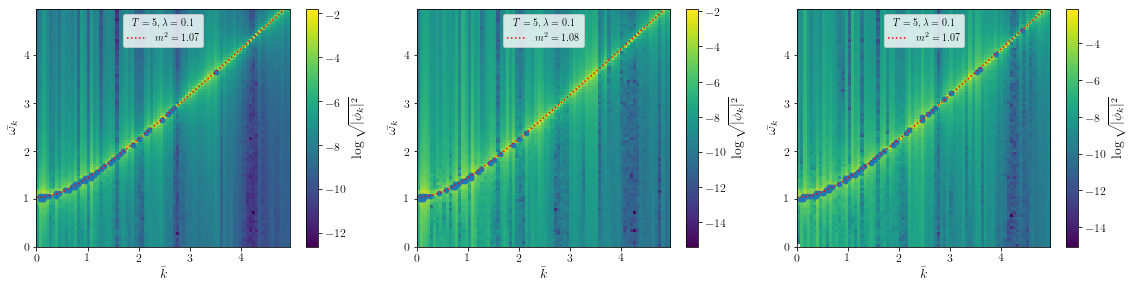

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


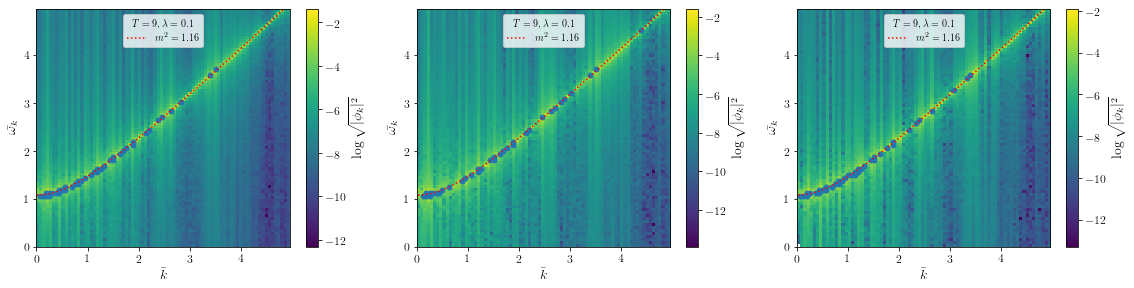

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


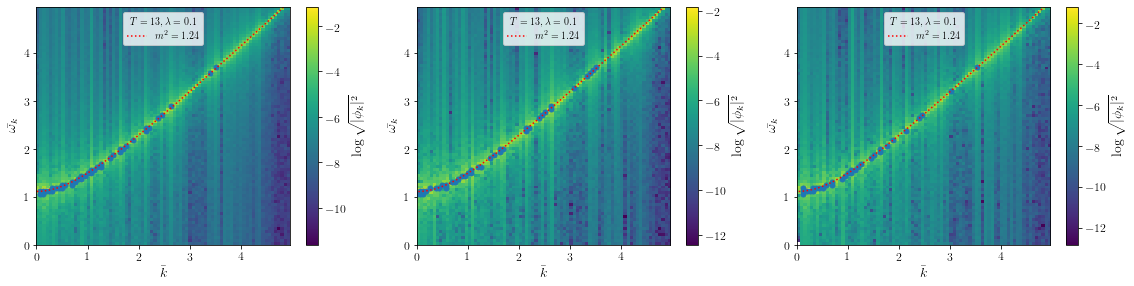

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


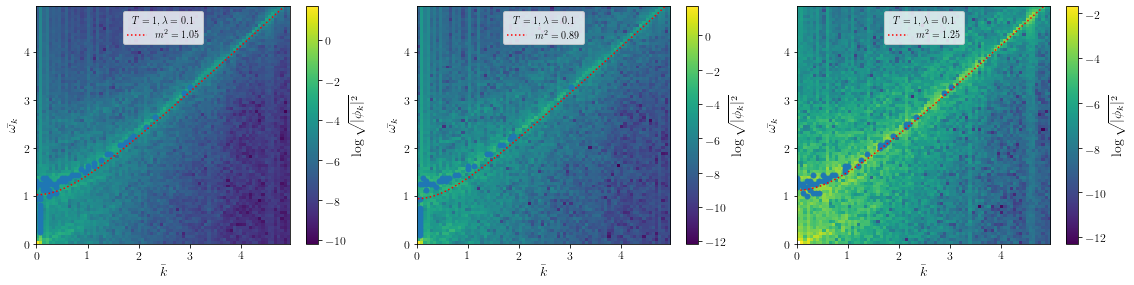

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


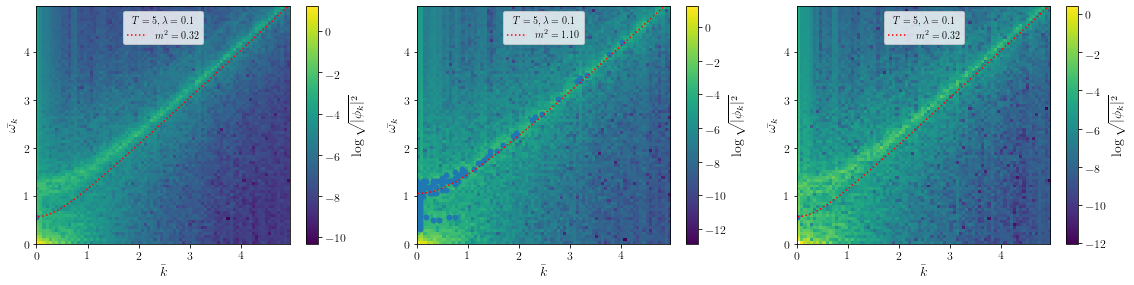

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


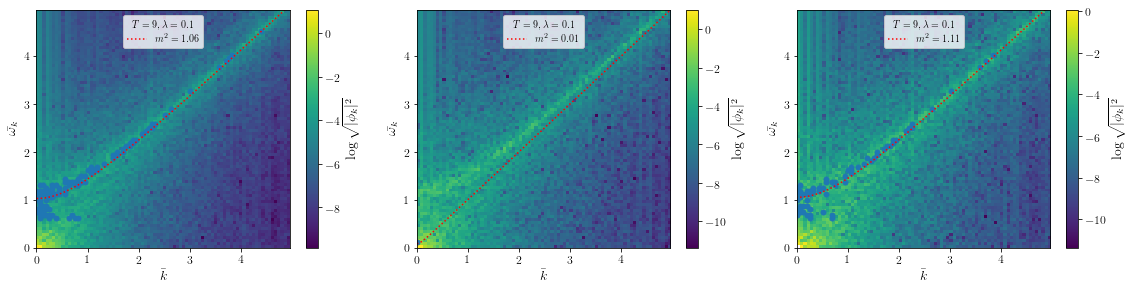

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in sqrt
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in sqrt
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


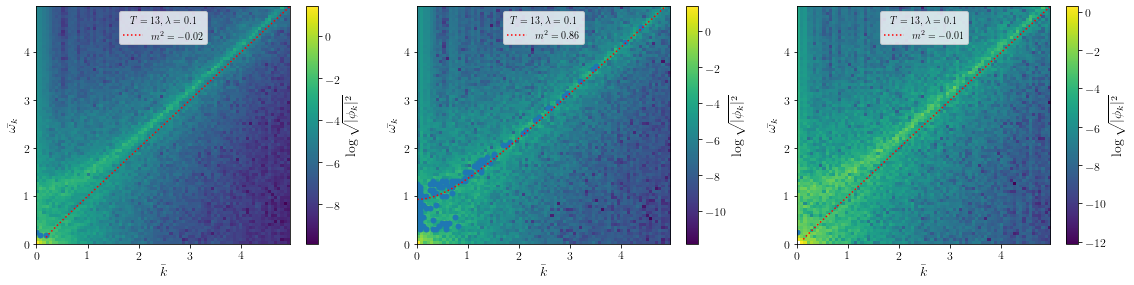

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


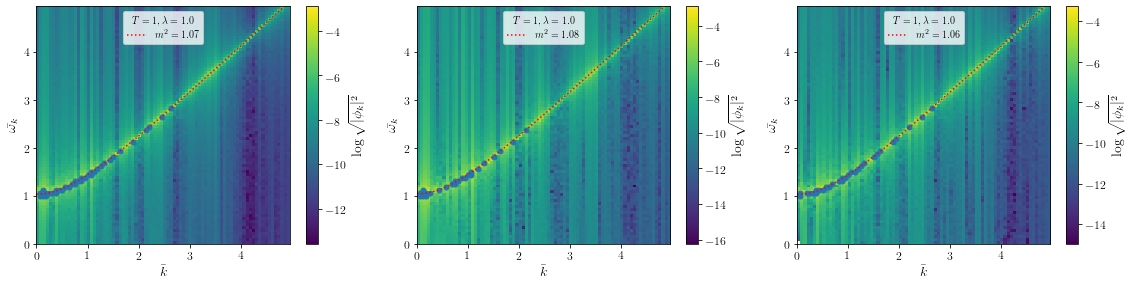

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


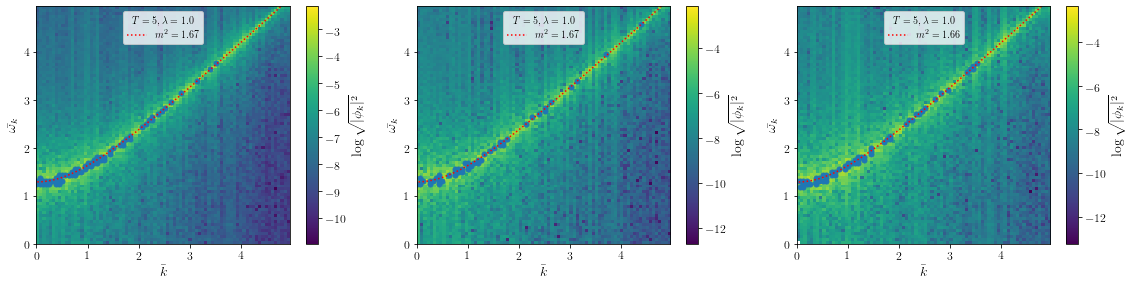

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


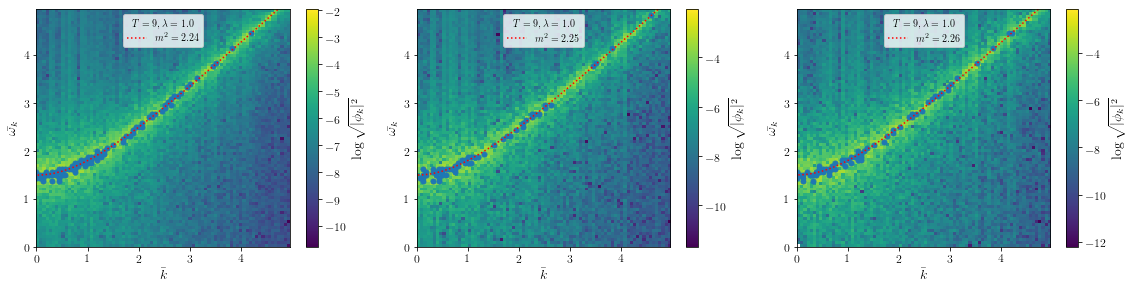

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


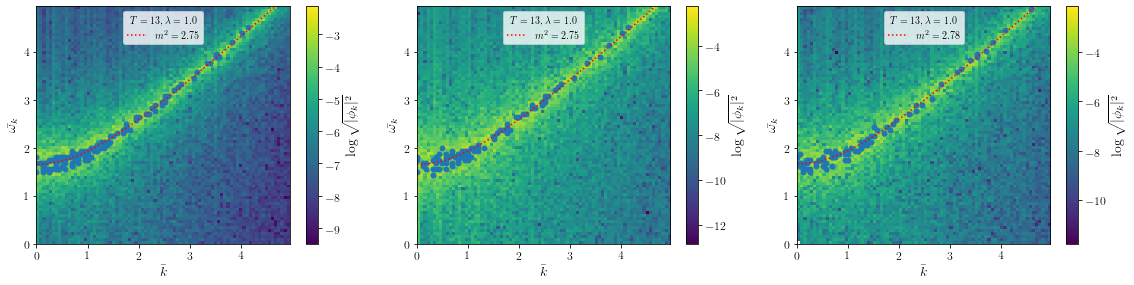

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in sqrt
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


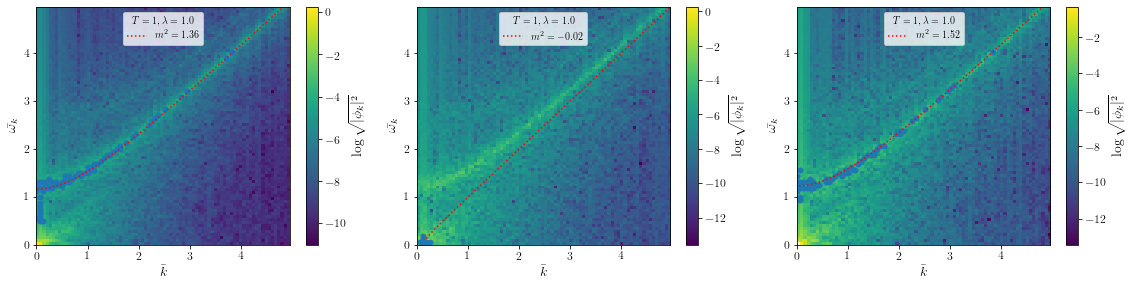

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in sqrt
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


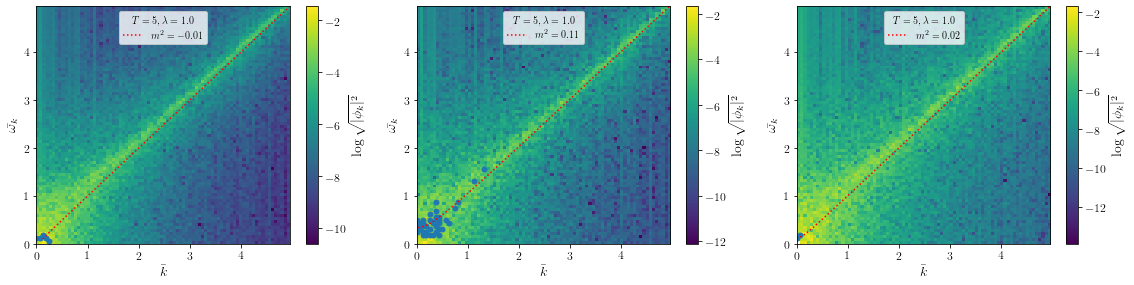

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


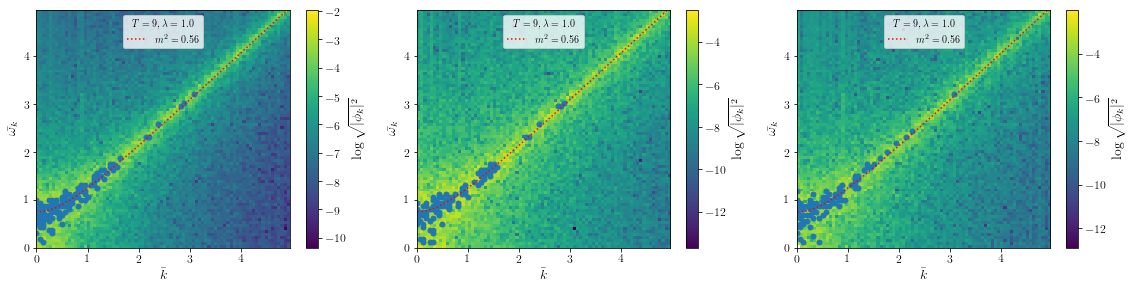

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


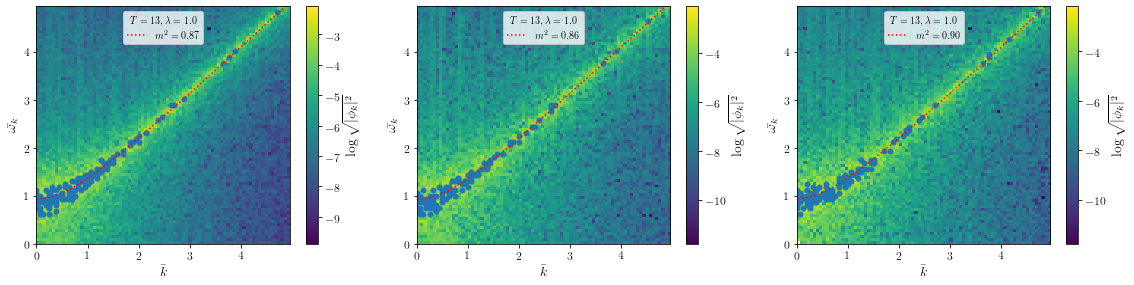

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


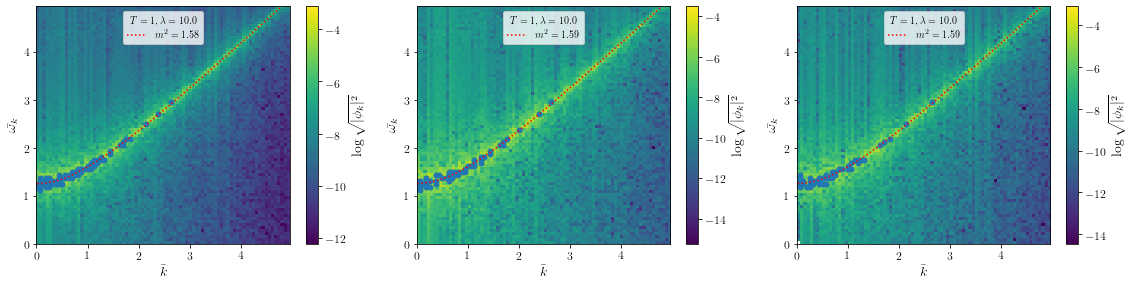

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


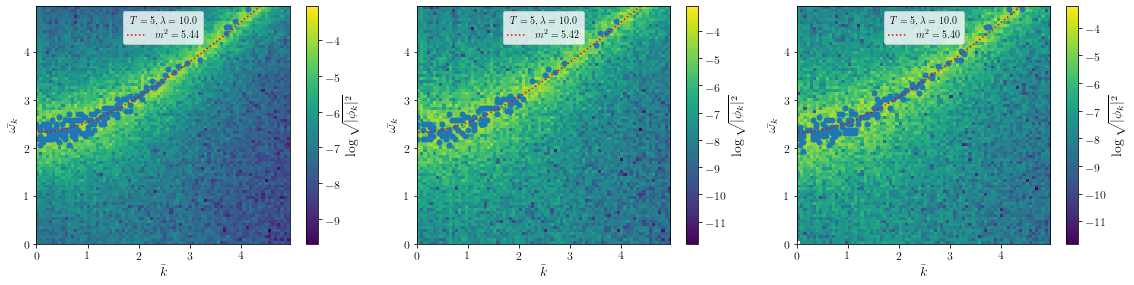

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


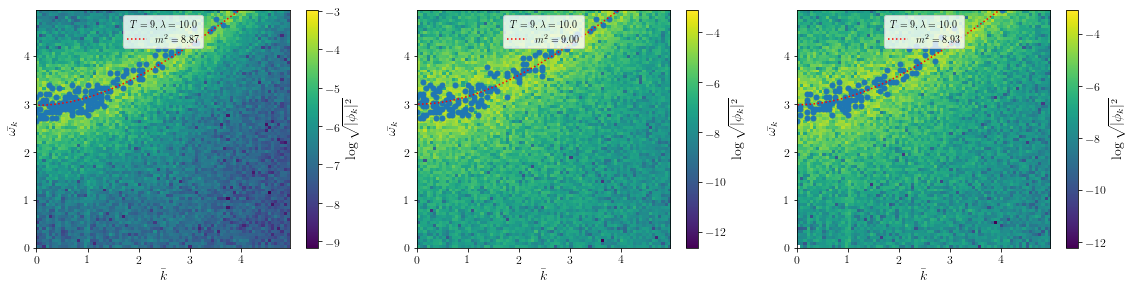

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


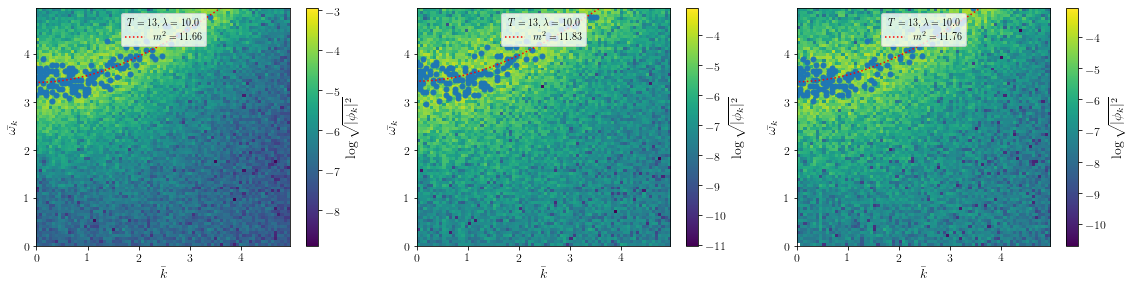

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in sqrt
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in sqrt
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


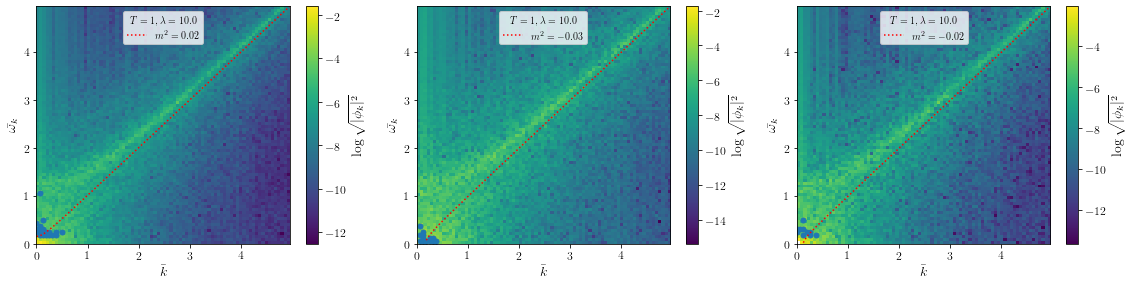

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


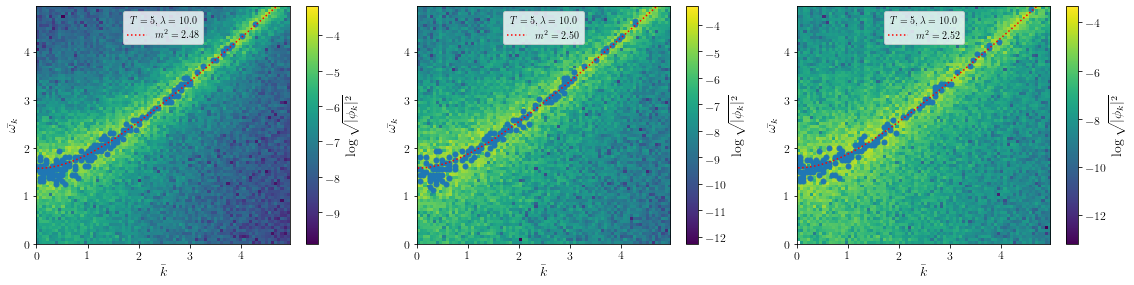

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


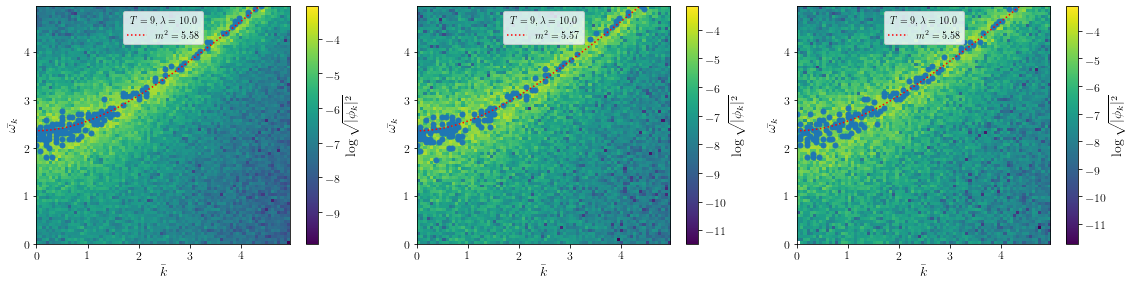

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


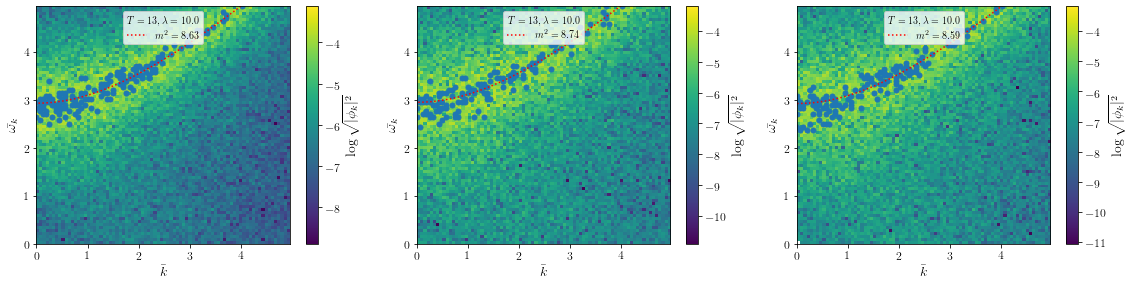

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


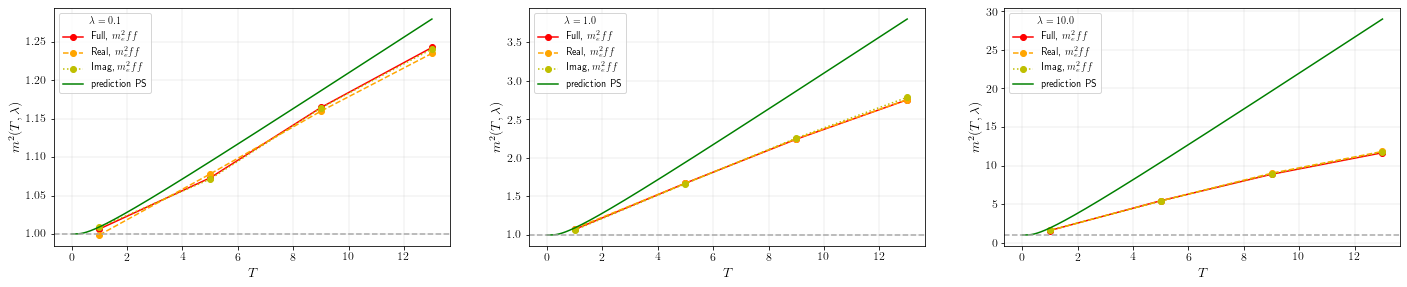

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


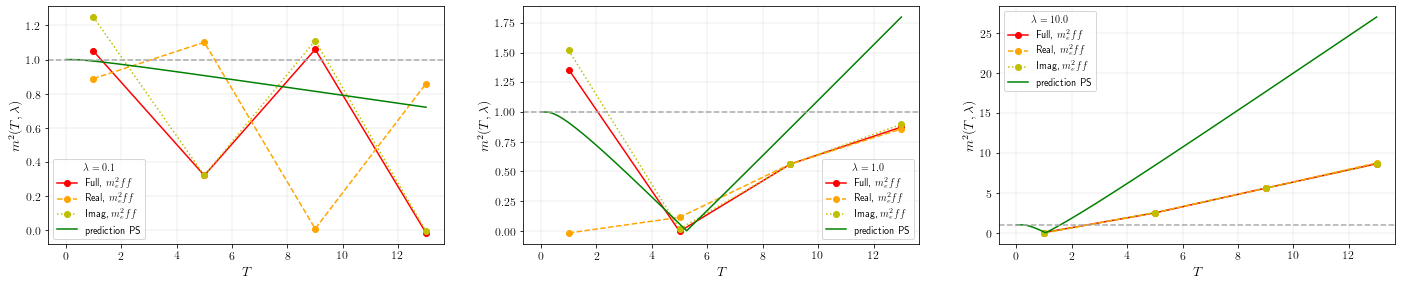

In [28]:
allMasses = [[get_masses_seps(ind, data, True, multiplier, lll, lamb, ggg, gamma, thresh) for ggg, gamma in enumerate(list_gamma)] for lll, lamb in enumerate(list_lamb)]

for ind, data in enumerate(all_data):
    title = ['Full, ', 'Real, ', 'Imag, ']
    for ggg, gamma in enumerate(list_gamma):
        fig, ax = plt.subplots(1, len(list_lamb), figsize=(25, 4))
        for lll, lamb in enumerate(list_lamb):
            colors = cycle(('red', 'orange', 'y', 'g', 'b'))

            linest = cycle(('-', '--', ':'))
            for iii, masses in enumerate(allMasses[lll][ggg]):
                ax[lll].plot(list_temp, masses, marker='o', linestyle=next(linest), color=next(colors), label=title[iii]+r'$m^2_eff$')

            ax[lll].plot(list_fine_temp, np.abs((m2bare if gamma==0 else -m2bare) + 0.5*lamb*sigma0sq_th(m2bare, list_fine_temp)), ':', linestyle='-', color=next(colors), label='prediction PS')
            ax[lll].legend(title=r'$\lambda = %5.1f$'%(lamb))

        for qwe in ax:
            qwe.axhline(m2bare, color='darkgray', ls='--', label='potential mass')
            qwe.set_ylabel(f'$m^2(T, \lambda)$')
            qwe.set_xlabel(f'$T$')
            qwe.grid(color='darkgray', linestyle='-', linewidth=0.2)
        plt.show()